#### Import Libraries

In [9]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.preprocessing import StandardScaler
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from skforecast.metrics import crps_from_predictions
warnings.filterwarnings("ignore")


In [ ]:
class Neural_Predictor(nn.Module):
    """
    Afeedforward neural network for multi-target forecast.

    Args:
        input_size (int): Number of input features.
        hidden_size (int): Number of units in the hidden layers.
        output_size (int): Number of output targets.
        batch_first (bool): If True, input and output tensors are provided as (batch, seq, feature).
        drop_rate (float): Dropout rate for regularization.
    """
    def __init__(self, input_size: int = 4, hidden_size: int = 24, output_size=3, drop_rate=0.25):
        super().__init__()
        self.output_size = output_size
        self.input_size = input_size
        self.drop_rate = drop_rate
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Dropout(drop_rate),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, int(hidden_size/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_size/2), int(hidden_size / 4)),
            nn.Dropout(drop_rate),
            nn.ReLU(),
            nn.Linear(int(hidden_size / 4), output_size)
        )

    def forward(self, x):
        """
        Forward pass of the neural network.
        Args:
            x (Tensor): Input tensor of shape (batch_size, input_size).
        Returns:
            Tensor: Output tensor of shape (batch_size, output_size).
        """
        output = self.model(x)
        return output


def loss_function(preds, targets):
    """
    Mean squared error loss function.
    Args:
        preds (Tensor): Predicted values.
        targets (Tensor): Ground truth values.
    Returns:
        Tensor: Computed MSE loss.
    """
    loss = F.mse_loss(preds, targets)
    return loss

In [11]:
### Predictor Class
class Predictor:
    """
    Predictor class for multi-target time series forecasting using a neural network.
    Handles data loading, preprocessing, normalization, model training, and prediction.
    """

    def __init__(self, iso='random'):
        """
        Predictor object constructor.
        Args:
            iso (str): Identifier for the ISO or region (default: 'random').
        """
        self.iso = iso
        self.predictions = {}
        self.metrics = {}
        self.targets = ['dalmp', 'rtlmp', 'wind_power_mw']
        self.inputs = ['system_load_forecast', 'system_solar_forecast', 'system_wind_forecast', 'outage_forecast']
        self.model = {}
        self.num_scenario = 100

    def read_train_test_data(self, train_file='data/train_data.parquet', test_file='data/test_data.parquet'):
        """
        Read training and testing data from parquet files.
        Args:
            train_file (str): Path to the training data file.
            test_file (str): Path to the testing data file.
        """
        self.train_data = pd.read_parquet(train_file)
        self.test_data = pd.read_parquet(test_file)

    def add_lagged_features(self):
        """
        Add lagged features to the training and testing data.
        """
        # Create lagged features for the target variables
        for target in self.targets:
            for i in range(1):
                self.train_data[f'{target}_lag_{i}'] = self.train_data[target].shift(i)
                # Save as CSV for inspection/debugging
        self.train_data.to_csv('train_data.csv')
        self.test_data.to_csv('test_data.csv')
                
        # Drop rows with NaN values created by lagging
        self.train_data = self.train_data.dropna()
        self.test_data = self.test_data.dropna()

    def preprocess_data(self):
        """
        Preprocess the data by removing NaNs and duplicates.
        """
        # Remove rows with any NaN values
        self.train_data = self.train_data.dropna()
        self.test_data = self.test_data.dropna()
        # Remove duplicate rows
        self.train_data = self.train_data.drop_duplicates()
        self.test_data = self.test_data.drop_duplicates()

    def separate_inputs_targets(self):
        """
        Separate input features and target variables for training and testing.
        """
        self.x_train = self.train_data[self.inputs]
        self.y_train = self.train_data[self.targets]
        self.x_test = self.test_data[self.inputs]

    def normalize_data(self):
        """
        Normalize the input and target data using StandardScaler.
        """
        self.scaler_input = StandardScaler()
        self.scaler_target = StandardScaler()
        self.x_train_norm = pd.DataFrame(self.scaler_input.fit_transform(self.x_train), columns=self.x_train.columns)
        self.x_test_norm = pd.DataFrame(self.scaler_input.transform(self.x_test), columns=self.x_test.columns)
        self.y_train_norm = pd.DataFrame(self.scaler_target.fit_transform(self.y_train), columns=self.y_train.columns)
        self.y_train_norm.to_csv('y_train_norm.csv')

    def calc_mean_std(self):
        """
        Calculate the mean and standard deviation of the target variables.
        """
        self.target_mean = self.y_train.mean()
        self.target_std = self.y_train.std()
        self.target_mean = self.target_mean.values
        self.target_std = self.target_std.values

    def calc_target_cov(self):
        """
        Calculate the covariance matrix of the normalized target variables.
        """
        self.target_cov = self.y_train_norm.cov()
        self.target_cov = self.target_cov.values

    def train_neural_model(self, epochs=50, lr=5e-6):
        """
        Train the neural network model on the training data.
        Args:
            epochs (int): Number of training epochs.
            lr (float): Learning rate for the optimizer.
        """
        self.Neural = Neural_Predictor()
        optimizer = torch.optim.Adam(self.Neural.model.parameters(), lr=lr)
        X = torch.tensor(self.x_train_norm.values, dtype=torch.float32)
        Y = torch.tensor(self.y_train_norm.values, dtype=torch.float32)
        dataset = TensorDataset(X, Y)
        train_loader = DataLoader(dataset, batch_size=1, shuffle=False)

        loss_history = []

        for ep in range(epochs):
            self.Neural.model.train()
            for x_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = self.Neural(x_batch)
                loss = loss_function(y_pred, y_batch)
                loss.backward()
                optimizer.step()
            loss_history.append(loss.item())
            if ep % 2 == 0:
                print(f"Epoch {ep}/{epochs}, Loss: {loss.item()}")

    def predict_neural_model(self):
        """
        Generate predictions using the trained neural network model for multiple scenarios.

        This method sets the model to training mode (for dropout, if used), then iterates over the number of scenarios,
        generating predictions for each scenario. The predictions are inverse-transformed to the original scale and
        stored in a dictionary, with each scenario's predictions as a DataFrame. All scenario DataFrames are then
        concatenated along the columns to form the final predictions DataFrame.
        Returns:
            dict: A dictionary where each key is a scenario index and each value is a DataFrame of predictions for that scenario.
        """
        self.Neural.model.train()
        y_pred = {}
        self.predictions = pd.DataFrame()
        with torch.no_grad():
            x_test_tensor = torch.tensor(self.x_test_norm.values, dtype=torch.float32)
            for i in range(self.num_scenario):
                scenario_cols = [t+'_'+str(i).zfill(3) for t in self.targets]
                preds_norm = self.Neural(x_test_tensor).numpy()/(1 - self.Neural.drop_rate)
                preds = self.scaler_target.inverse_transform(preds_norm)
                y_pred[i] = pd.DataFrame(preds, columns = scenario_cols, index = self.x_test.index)
            self.predictions = pd.concat(y_pred, axis=1)
            #drop the first level of the columns
            self.predictions.columns = self.predictions.columns.droplevel(0)
            #order columns alphabetically
            self.predictions = self.predictions.reindex(sorted(self.predictions.columns), axis=1)
            self.predictions.to_csv('predictions.csv')
   
        return self.predictions  
    
    def graph_percentiles(self):
        """
        Generate and save plots of the 5th, 50th, and 95th percentiles of the predictions.
        for the target variables.
        the columns are names as scenario_cols = [t+'_'+str(i).zfill(3) for t in self.targets]
        """
        import matplotlib.pyplot as plt
        import seaborn as sns

        # Set the style of seaborn
        sns.set(style="whitegrid")

        # Create a figure and axis for each target variable
        for target in self.targets:
            plt.figure(figsize=(12, 6))
            # Calculate the percentiles
            percentiles = self.predictions[[col for col in self.predictions.columns if col.startswith(target)]].quantile([0.05, 0.5, 0.95], axis=1)
            percentiles = percentiles.transpose()
            # Plot the percentiles
            plt.plot(percentiles[0.5], label='50th Percentile', color='red')
            plt.fill_between(percentiles.index, percentiles[0.05], percentiles[0.95], color='orange', alpha=0.5, label='90% Prediction Interval')
            plt.title(f'Predicted {target} Percentiles')
            plt.xlabel('Time')
            plt.ylabel(target)
            plt.legend()
            plt.savefig(f'{target}_percentiles.png')
            plt.show()
            plt.close()

Epoch 0/50, Loss: 0.47790423035621643
Epoch 2/50, Loss: 0.7003917694091797
Epoch 4/50, Loss: 0.3240986764431
Epoch 6/50, Loss: 0.2474394589662552
Epoch 8/50, Loss: 0.11709464341402054
Epoch 10/50, Loss: 0.09262397140264511
Epoch 12/50, Loss: 0.4705623686313629
Epoch 14/50, Loss: 0.1852964162826538
Epoch 16/50, Loss: 0.3812851011753082
Epoch 18/50, Loss: 0.07842478156089783
Epoch 20/50, Loss: 0.08303876966238022
Epoch 22/50, Loss: 0.10329532623291016
Epoch 24/50, Loss: 0.08693098276853561
Epoch 26/50, Loss: 0.251520574092865
Epoch 28/50, Loss: 0.060681045055389404
Epoch 30/50, Loss: 0.0935920774936676
Epoch 32/50, Loss: 0.10079076141119003
Epoch 34/50, Loss: 0.3394112288951874
Epoch 36/50, Loss: 0.32398054003715515
Epoch 38/50, Loss: 0.32805755734443665
Epoch 40/50, Loss: 0.13476984202861786
Epoch 42/50, Loss: 0.08617988973855972
Epoch 44/50, Loss: 0.060390904545784
Epoch 46/50, Loss: 0.06443527340888977
Epoch 48/50, Loss: 0.3705315887928009


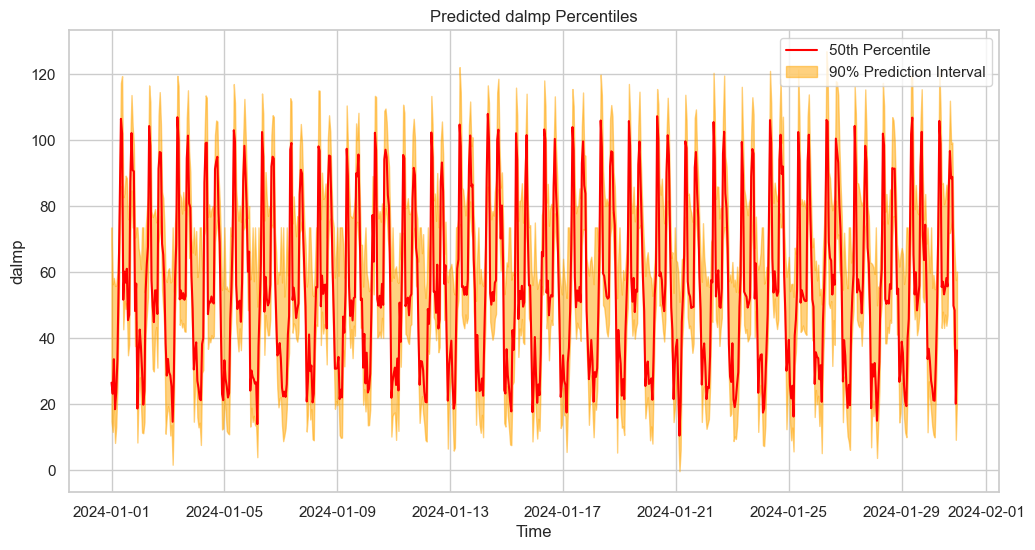

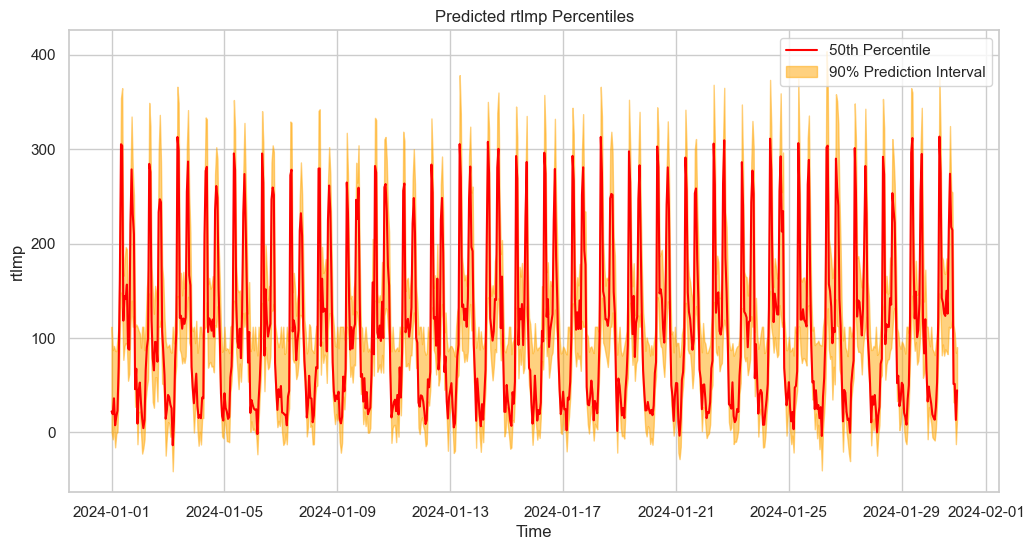

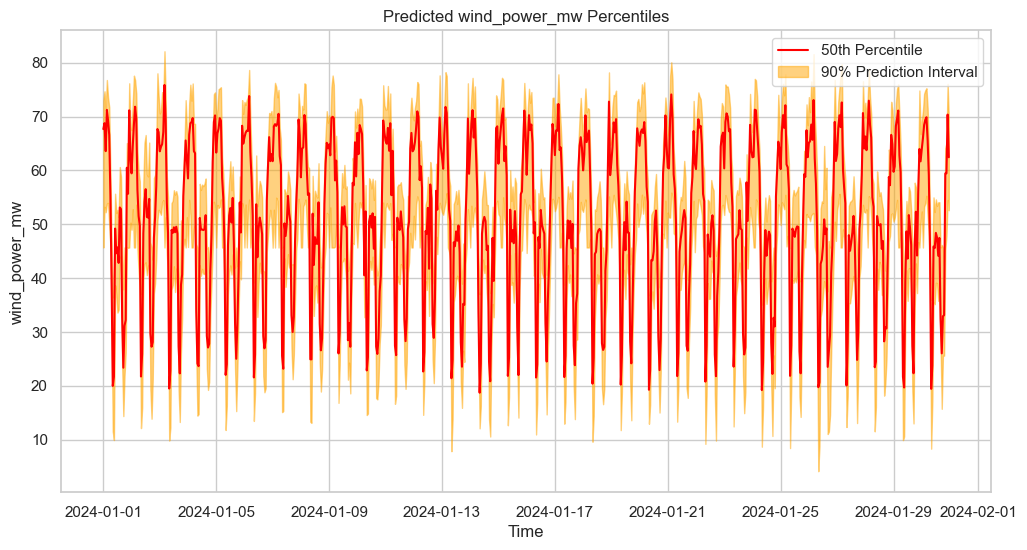

In [12]:
# Instantiate the Predictor class for multi-target time series forecasting
test_forecaster = Predictor()

# Read training and testing data from parquet files
test_forecaster.read_train_test_data()

# Preprocess the data by removing NaNs and duplicates
test_forecaster.preprocess_data()
# Separate input features and target variables for training and testing
test_forecaster.separate_inputs_targets()

# Normalize the input and target data using StandardScaler
test_forecaster.normalize_data()

# Calculate the covariance matrix of the normalized target variables
test_forecaster.calc_target_cov()

# Train the neural network model on the training data
test_forecaster.train_neural_model()

# Generate predictions using the trained neural network model for multiple scenarios
preds = test_forecaster.predict_neural_model()

test_forecaster.graph_percentiles()